<img src="https://upload.wikimedia.org/wikipedia/commons/0/06/Imperial_College_London_new_logo.png" alt="Imperial Logo" width="400">

### **Course:** CIVE70111 Machine Learning
### Task 2 Plant Modelling and Machine Learning Pipeline

**Project:** Plant 2 — Data Exploration, Analysis and Preprocessing

**Date:** 09/12/2025  

<p align="right">
Created by: Michael Wong

# 📘 **TABLE OF CONTENTS**

- [📖 Project Overview & Workflow](#project-overview--workflow)
- [📂 Section 1 — Load Generation Data](#section-1--load-generation-data)
- [📂 Section 2 — Explore Raw Inverter Readings](#section-2--explore-raw-inverter-readings)
- [📂 Section 3 — Verify Timestamp Stability](#section-3--verify-timestamp-stability)
- [📂 Section 4 — Aggregate Inverter Data](#section-4--aggregate-inverter-data)
- [📂 Section 5 — Load & Inspect Weather Data](#section-5--load--inspect-weather-data)
- [📂 Section 6 — Clean Irradiation](#section-6--clean-irradiation)
- [📂 Section 7 — Join Weather + Inverter Data](#section-7--join-weather--inverter-data)
- [📂 Section 8 — Clean AC and DC Power](#section-8--clean-ac-and-dc-power)
- [📂 Section 9 — Clean DAILY_YIELD](#section-9--clean-daily_yield)
- [📂 Section 10 — Clean TOTAL_YIELD](#section-10--clean-total_yield)
- [📂 Section 11 — Outlier Detection](#section-11--outlier-detection)
- [📂 Section 12 — Exploratory Data Analysis](#section-12--exploratory-data-analysis)
- [📂 Section 13 — Correlation Analysis](#section-13--correlation-analysis)
- [📂 Section 14 — Final Notes](#section-14--final-notes)


# 📖 **PROJECT OVERVIEW & WORKFLOW**

This project performs complete cleaning and exploratory analysis of **Plant 2 solar generation data** and **weather sensor data**.  
The workflow ensures physically consistent, anomaly-free time series suitable for modelling and diagnostics.

---

## **Workflow Summary**

1. Load raw generation data and split by inverter  
2. Visualize raw AC/DC, yield, and temperature signals  
3. Validate multiple readings per timestamp  
4. Aggregate inverter measurements  
5. Load weather data and clean irradiation  
6. Join weather and generation datasets  
7. Clean AC/DC values using day/night rules  
8. Clean DAILY_YIELD with monotonic interpolation  
9. Clean TOTAL_YIELD using DAILY_YIELD deltas  
10. Detect outliers using regression-residual z-scores  
11. Generate time-series plots, zoom-ins, and distributions  
12. Compute correlation matrices and heatmaps  

---

This document follows a structured, section-by-section pipeline with clean code blocks for each step.


# 📂 SECTIONED CODE BLOCKS  
Below are the modular code sections used in this project.  
Each section includes a **brief description** followed by the corresponding **Python code block**.

---

## 📂 **Section 1 — Load Generation Data**
**Description:**  
This section loads the raw Plant 2 generation dataset, removes unnecessary columns (such as PLANT_ID), sets the timestamp as the index, and checks for missing values.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import datetime as dt
from sklearn.linear_model import LinearRegression




###############################################################################################################################################################
# Change here
# File paths
folder = r"C:\Users\B.KING\OneDrive - Imperial College London\CIVE70111 Machine Learning\CouseWork\Group-11\data\In"
###############################################################################################################################################################
gen_path_2 = os.path.join(folder, "Plant_2_Generation_Data.csv")
weather_path_2 = os.path.join(folder, "Plant_2_Weather_Sensor_Data.csv")

plant_2 = pd.read_csv(gen_path_2, parse_dates=['DATE_TIME'])
plant_2 = plant_2.drop(columns=['PLANT_ID'])
plant_2.set_index('DATE_TIME', inplace=True)

print("Missing values in generation data:")
print(plant_2.isnull().sum())


Missing values in generation data:
SOURCE_KEY             0
DC_POWER               0
AC_POWER               0
DAILY_YIELD            0
TOTAL_YIELD            0
Operating_Condition    0
dtype: int64



---

## 📂 **Section 2 — Explore Raw Inverter Readings**
**Description:**  
Plots the raw AC/DC power, yields, and temperature-related signals for a sample inverter to visually inspect trends, noise, and anomalies before cleaning.


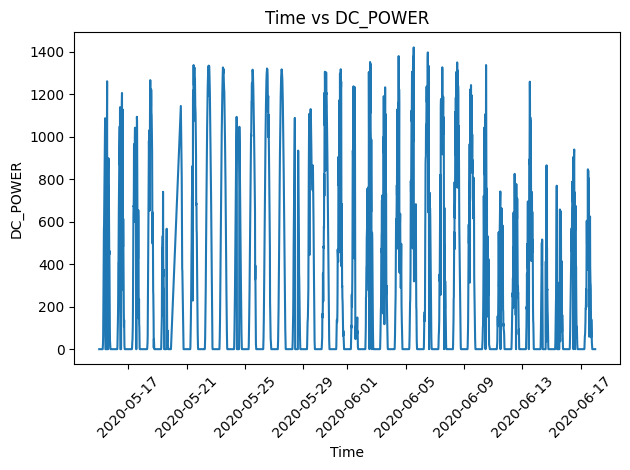

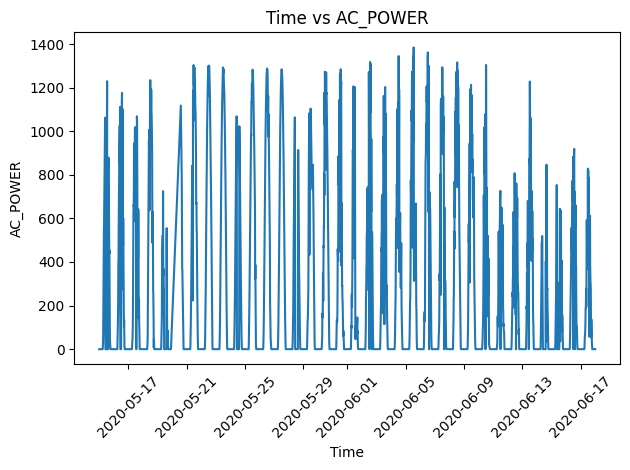

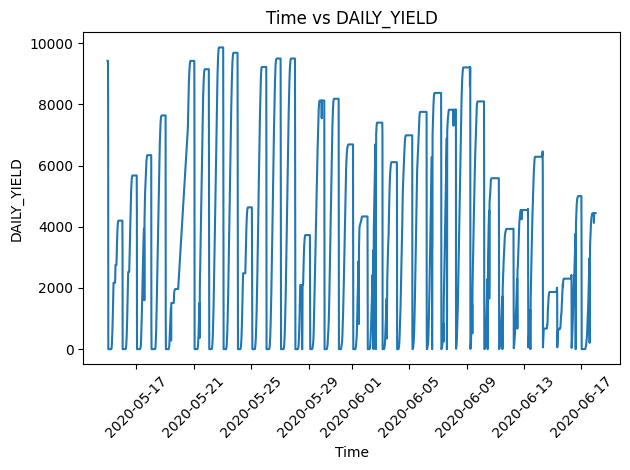

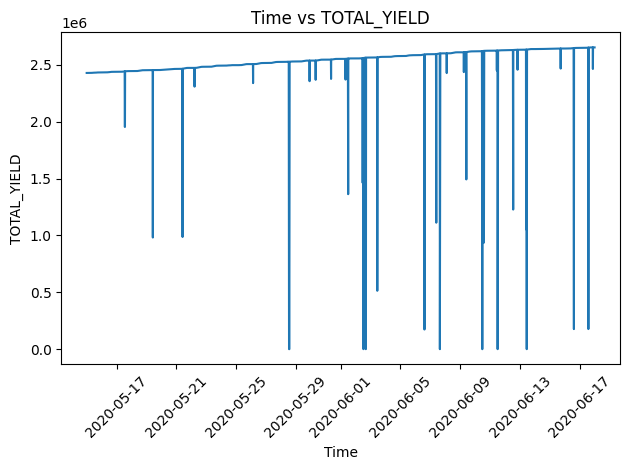

In [2]:
inv_2 = {k: v.copy() for k, v in plant_2.groupby('SOURCE_KEY')}
source_key_2 = list(inv_2.keys())

sk2 = inv_2[source_key_2[0]].drop(columns=['SOURCE_KEY', 'Operating_Condition'])

for col in sk2.columns:
    plt.figure()
    plt.plot(sk2.index, sk2[col])
    plt.title(f"Time vs {col}")
    plt.xlabel("Time")
    plt.ylabel(col)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


---

## 📂 **Section 3 — Verify Timestamp Stability**
**Description:**  
Ensures that for every timestamp, all measurements are internally consistent (e.g., AC_POWER has only one value per time). Identifies inverters with duplicated or inconsistent data.


In [3]:
for sk in source_key_2:
    df = inv_2[sk].groupby("DATE_TIME")
    cols = ['DC_POWER', 'AC_POWER', 'DAILY_YIELD', 'TOTAL_YIELD']
    const_check = (df[cols].nunique() == 1).reset_index()
    not_constant = (~const_check[cols]).sum()

    print(f"\n{sk} non-constant counts:\n{not_constant}")



4UPUqMRk7TRMgml non-constant counts:
DC_POWER       0
AC_POWER       0
DAILY_YIELD    0
TOTAL_YIELD    0
dtype: int64

81aHJ1q11NBPMrL non-constant counts:
DC_POWER       0
AC_POWER       0
DAILY_YIELD    0
TOTAL_YIELD    0
dtype: int64

9kRcWv60rDACzjR non-constant counts:
DC_POWER       0
AC_POWER       0
DAILY_YIELD    0
TOTAL_YIELD    0
dtype: int64

Et9kgGMDl729KT4 non-constant counts:
DC_POWER       0
AC_POWER       0
DAILY_YIELD    0
TOTAL_YIELD    0
dtype: int64

IQ2d7wF4YD8zU1Q non-constant counts:
DC_POWER       0
AC_POWER       0
DAILY_YIELD    0
TOTAL_YIELD    0
dtype: int64

LYwnQax7tkwH5Cb non-constant counts:
DC_POWER       0
AC_POWER       0
DAILY_YIELD    0
TOTAL_YIELD    0
dtype: int64

LlT2YUhhzqhg5Sw non-constant counts:
DC_POWER       0
AC_POWER       0
DAILY_YIELD    0
TOTAL_YIELD    0
dtype: int64

Mx2yZCDsyf6DPfv non-constant counts:
DC_POWER       0
AC_POWER       0
DAILY_YIELD    0
TOTAL_YIELD    0
dtype: int64

NgDl19wMapZy17u non-constant counts:
DC_POWER  


---
## 📂 **Section 4 — Aggregate Inverter Data**
**Description:**  
Aggregates raw inverter records into a single row per timestamp per inverter, using the first valid reading for each variable and computing counts of operating-condition labels.


In [4]:
agg_inv_2 = {}

for sk, df in inv_2.items():
    agg_inv_2[sk] = (
        df.groupby("DATE_TIME")
        .agg(
            SOURCE_KEY=("SOURCE_KEY", "first"),
            DC_POWER=("DC_POWER", "first"),
            AC_POWER=("AC_POWER", "first"),
            DAILY_YIELD=("DAILY_YIELD", "first"),
            TOTAL_YIELD=("TOTAL_YIELD", "first"),
            NUM_OPT=("Operating_Condition", lambda x: (x == "Optimal").sum()),
            NUM_SUBOPT=("Operating_Condition", lambda x: (x == "Suboptimal").sum())
        )
        .reset_index()
    )



---

## 📂 **Section 5 — Load & Inspect Weather Data**
**Description:**  
Loads the weather dataset, removes plant/inverter identifiers, inspects missing values, and plots each weather variable across time.


Missing values in weather data:
AMBIENT_TEMPERATURE    0
MODULE_TEMPERATURE     0
IRRADIATION            0
dtype: int64


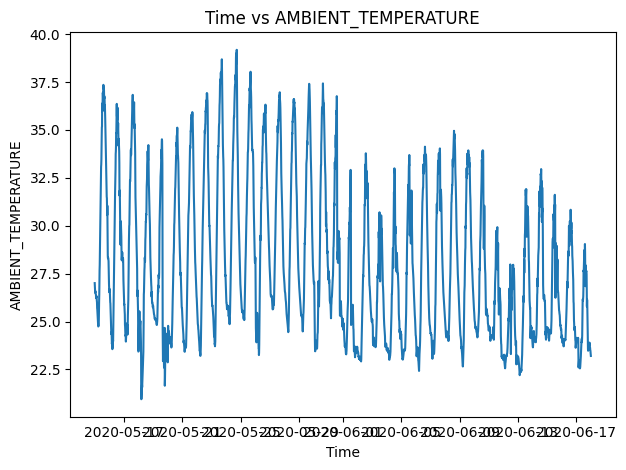

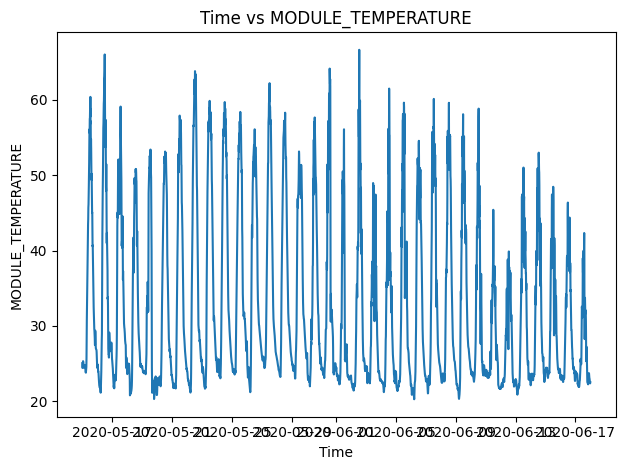

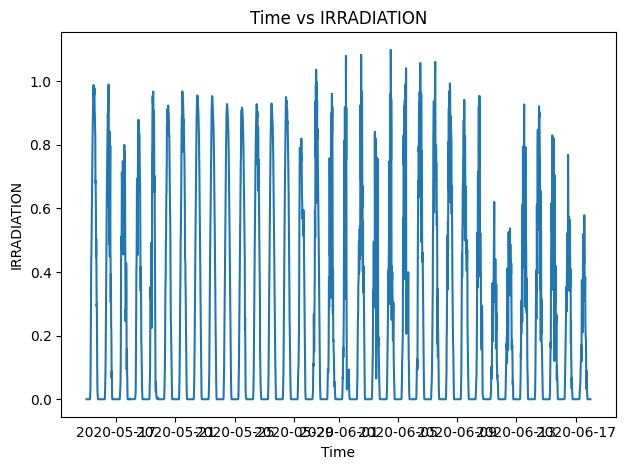

In [5]:
weather = pd.read_csv(weather_path_2, parse_dates=['DATE_TIME'])
weather_2 = weather.drop(columns=['PLANT_ID','SOURCE_KEY']).set_index('DATE_TIME')

print("Missing values in weather data:")
print(weather_2.isnull().sum())

for col in weather_2.columns:
    plt.figure()
    plt.plot(weather_2.index, weather_2[col])
    plt.xlabel("Time")
    plt.ylabel(col)
    plt.title(f"Time vs {col}")
    plt.tight_layout()
    plt.show()



---

## 📂 **Section 6 — Clean Irradiation**
**Description:**  
Applies domain rules to correct the IRRADIATION signal:
- Irradiation > 0 is invalid during night  
- Night-time irradiation is forced to zero  
- Creates `IRRADIATION_CLEAN` used for AC/DC and yield cleaning  


In [6]:
df = weather.copy()
df['DATE_TIME'] = pd.to_datetime(df['DATE_TIME'])

day_start, day_end = dt.time(6, 0), dt.time(18, 30)
df["expected_day"] = df["DATE_TIME"].dt.time.between(day_start, day_end)
df["irr_anom"] = (~df["expected_day"]) & (df["IRRADIATION"] > 0)

df["IRRADIATION_CLEAN"] = df["IRRADIATION"]
df.loc[(~df["expected_day"]) & (df["IRRADIATION_CLEAN"] > 0), "IRRADIATION_CLEAN"] = 0

s2_c = df.drop(columns=['IRRADIATION','expected_day','irr_anom','SOURCE_KEY'])
s2_c.set_index("DATE_TIME", inplace=True)



---

## 📂 **Section 7 — Join Weather + Inverter Data**
**Description:**  
Merges cleaned weather data with aggregated inverter data on timestamp, producing a synchronized dataset for each inverter.


In [7]:
wea_inv_2 = {}

for sk, df in agg_inv_2.items():
    df = df.set_index("DATE_TIME").copy()
    wea_inv_2[sk] = df.join(s2_c, how="inner", lsuffix="_inv", rsuffix="_wea")


---

## 📂 **Section 8 — Clean AC and DC Power**
**Description:**  
Enforces physical constraints on AC/DC signals:
- During night → AC/DC = 0  
- During day → AC/DC cannot be zero (treated as missing)  
- Interpolates missing daytime values linearly  


In [8]:
df_step_1 = {}

for sk, df in wea_inv_2.items():
    df = df.copy()

    df["AC_CLEAN"] = df["AC_POWER"]
    df["DC_CLEAN"] = df["DC_POWER"]

    night = df["IRRADIATION_CLEAN"] == 0
    df.loc[night & (df["AC_CLEAN"] > 0), "AC_CLEAN"] = 0
    df.loc[night & (df["DC_CLEAN"] > 0), "DC_CLEAN"] = 0

    day = df["IRRADIATION_CLEAN"] > 0
    df.loc[day & (df["AC_CLEAN"] == 0), "AC_CLEAN"] = np.nan
    df.loc[day & (df["DC_CLEAN"] == 0), "DC_CLEAN"] = np.nan

    df["AC_CLEAN"] = df["AC_CLEAN"].interpolate().fillna(0)
    df["DC_CLEAN"] = df["DC_CLEAN"].interpolate().fillna(0)

    df_step_1[sk] = df


---

## 📂 **Section 9 — Clean DAILY_YIELD**
**Description:**  
Cleans DAILY_YIELD using strict PV-system rules:
- Nighttime → always zero  
- Evening → constant at last daytime yield  
- Daytime → strictly increasing  
- Invalid points replaced and interpolated  

This ensures physically realistic daily yield curves.


In [9]:
df_step_2 = {}

for sk, df in df_step_1.items():
    df = df.copy()
    df.index = pd.to_datetime(df.index)
    df["DAILY_YIELD_CLEAN"] = df["DAILY_YIELD"]

    for date in np.unique(df.index.date):
        mask = df.index.date == date
        df_day = df.loc[mask]
        irr = df_day["IRRADIATION_CLEAN"] > 0

        if not irr.any():
            df.loc[mask, "DAILY_YIELD_CLEAN"] = 0
            continue

        start = df_day[irr].index[0]
        end = df_day[irr].index[-1]

        night_mask = mask & (df.index < start)
        eve_mask = mask & (df.index > end)
        day_mask = mask & (df.index >= start) & (df.index <= end)

        df.loc[night_mask, "DAILY_YIELD_CLEAN"] = 0
        df.loc[eve_mask, "DAILY_YIELD_CLEAN"] = df.at[end, "DAILY_YIELD"]

        idx = df.loc[day_mask].index
        raw = df.loc[idx, "DAILY_YIELD_CLEAN"].astype(float).values
        invalid = raw <= 0

        if len(raw) > 1:
            drops = np.diff(raw) < 0
            invalid[1:][drops] = True

        df.loc[idx[invalid], "DAILY_YIELD_CLEAN"] = np.nan
        df.loc[idx, "DAILY_YIELD_CLEAN"] = (
            df.loc[idx, "DAILY_YIELD_CLEAN"].interpolate(limit_direction='both')
        )

        prev = df.at[idx[0], "DAILY_YIELD_CLEAN"]
        for t in idx[1:]:
            cur = df.at[t, "DAILY_YIELD_CLEAN"]
            if pd.isna(cur) or cur < prev:
                df.at[t, "DAILY_YIELD_CLEAN"] = prev
            prev = df.at[t, "DAILY_YIELD_CLEAN"]

    df_step_2[sk] = df


---

## 📂 **Section 10 — Clean TOTAL_YIELD**
**Description:**  
Corrects TOTAL_YIELD using DAILY_YIELD changes:
- TOTAL_YIELD never decreases within the same day  
- If it drops, compute expected value using Δ(DY)  
- At midnight, TOTAL_YIELD resets to previous day’s final value  

Fixes counter resets and sensor glitches.


In [10]:
df_ps2 = {}

for sk, df in df_step_2.items():
    df = df.copy()
    df["TOTAL_YIELD_CLEAN"] = df["TOTAL_YIELD"]

    ts = df.index

    for i in range(1, len(ts)):
        t, t_prev = ts[i], ts[i-1]

        TY_prev = df.at[t_prev, "TOTAL_YIELD_CLEAN"]
        TY_now = df.at[t, "TOTAL_YIELD"]

        DY_prev = df.at[t_prev, "DAILY_YIELD_CLEAN"]
        DY_now = df.at[t, "DAILY_YIELD_CLEAN"]

        if t.date() != t_prev.date():
            df.at[t, "TOTAL_YIELD_CLEAN"] = TY_prev
            continue

        TY_expected = TY_prev + (DY_now - DY_prev)

        if TY_now < TY_prev:
            df.at[t, "TOTAL_YIELD_CLEAN"] = TY_expected
        else:
            df.at[t, "TOTAL_YIELD_CLEAN"] = TY_now
    
    df = df[['PLANT_ID','SOURCE_KEY', 
             'AC_CLEAN','DC_CLEAN',
             'DAILY_YIELD_CLEAN','TOTAL_YIELD_CLEAN', 
             'AMBIENT_TEMPERATURE', 
             'MODULE_TEMPERATURE','IRRADIATION_CLEAN',
            'NUM_OPT','NUM_SUBOPT']]
    
    df["OPERATING_CONDITION_CLEAN"] = np.where(
        df["NUM_OPT"] > df["NUM_SUBOPT"], "Optimal", "Suboptimal"
    )

    df = df.drop(columns=["NUM_OPT", "NUM_SUBOPT"])
    df_ps2[sk] = df


## 📂 **Section 10.5 — AC_CLEAN Relationship Plots (Scatter Analysis)**
**Description:**  
Before applying regression-based outlier detection, this section visualizes the relationship between `AC_CLEAN` and other cleaned variables.  
Since the correlation matrix is nearly identical across all inverters, one inverter is representative for understanding system behavior.

These scatter plots confirm:
- AC_CLEAN is strongly linearly correlated with IRRADIATION_CLEAN  
- DC_CLEAN follows the exact same trend (DC ↔ AC correlation)  
- Outliers appear as points far away from the linear trend  


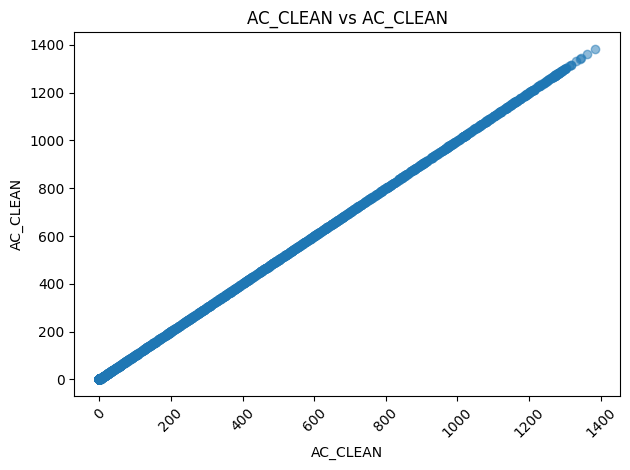

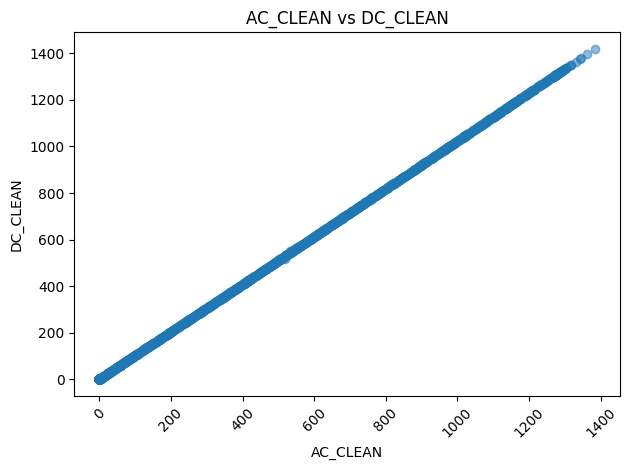

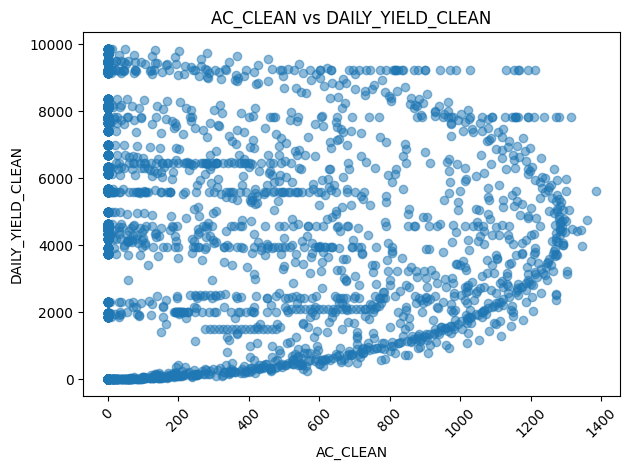

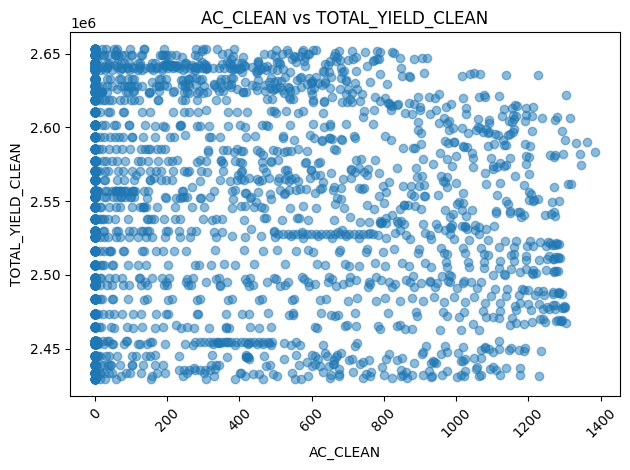

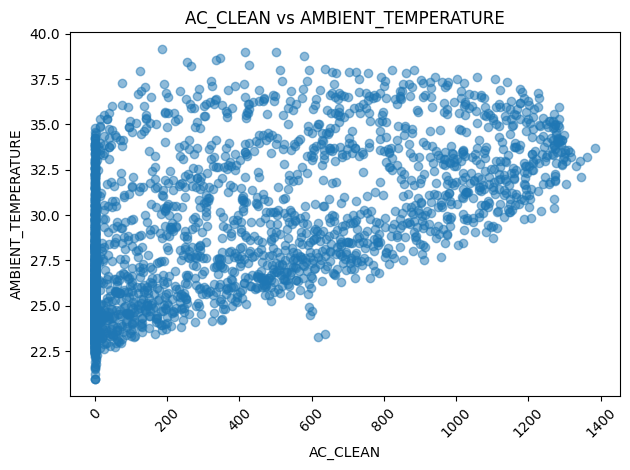

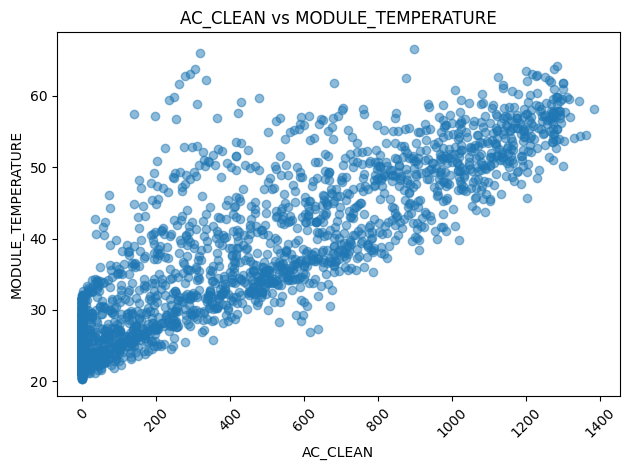

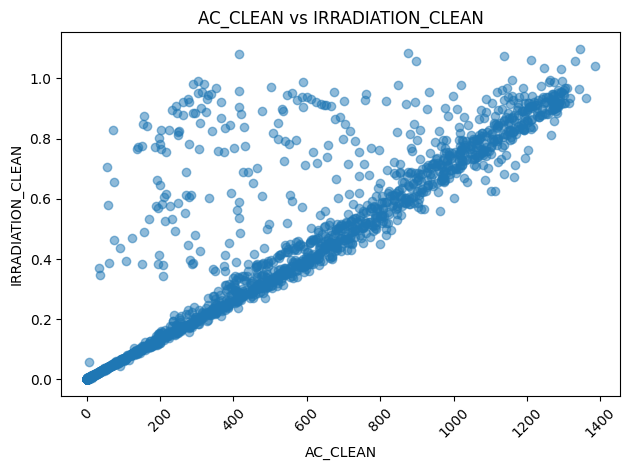

In [11]:
# Use example inverter for scatter analysis
eg = df_ps2[source_key_2[0]].drop(
    columns=['PLANT_ID', 'SOURCE_KEY', 'OPERATING_CONDITION_CLEAN']
)

# Scatter plots: AC_CLEAN vs every other feature
for column in eg.columns:
    plt.figure()
    plt.scatter(eg["AC_CLEAN"], eg[column], alpha=0.5)
    plt.xlabel("AC_CLEAN")
    plt.ylabel(column)
    plt.title(f"AC_CLEAN vs {column}")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Notes:
# - AC is linearly correlated with irradiation
# - DC also correlates linearly because AC and DC are near-perfectly related
# - Outliers appear as deviations from the linear cluster


---

## 📂 **Section 11 — Outlier Detection**
**Description:**  
Detects outliers using a regression model between Irradiation and AC Power:
- Compute residuals  
- Convert residuals to z-scores  
- Mark points with |z| > threshold as outliers  
- Optionally remove them  

This isolates physically implausible AC readings.


Shape of original dataframe: 3195
Shape of cleaned dataframe: 3100


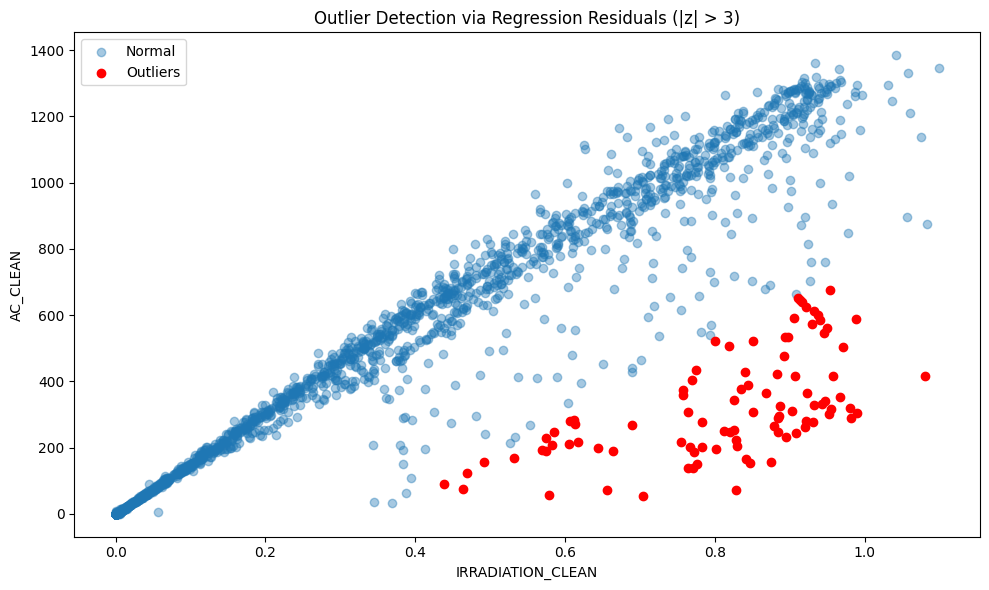

In [12]:
def regression_outlier_detection_graph(df, x_col="IRRADIATION_CLEAN", y_col="AC_CLEAN", z_thresh=3, plot=True):
    """
    Detect outliers based on regression residuals between x_col and y_col.
    Points with |z-score(residual)| > z_thresh are flagged as outliers.

    Parameters
    ----------
    df : pandas.DataFrame
        Input dataframe containing x_col and y_col.
    x_col : str
        Name of the explanatory variable (e.g. IRRADIATION_CLEAN).
    y_col : str
        Name of the response variable (e.g. AC_CLEAN).
    z_thresh : float
        Z-score threshold for outlier detection.
    plot : bool
        If True, plots normal points vs outliers.

    Returns
    -------
    df_clean : pandas.DataFrame
        Dataframe with outliers removed.
    """
    df = df.copy()

    # Prepare data
    X = df[[x_col]].values
    y = df[y_col].values

    # Fit linear regression
    model = LinearRegression()
    model.fit(X, y)
    y_pred = model.predict(X)

    # Residuals and z-scores
    residuals = y - y_pred
    z = (residuals - residuals.mean()) / residuals.std()

    # Flag outliers
    df["outlier_reg"] = np.abs(z) > z_thresh

    # Create cleaned dataframe
    df_clean = df[df["outlier_reg"] == False].drop(columns=["outlier_reg"])

    if plot:
        plt.figure(figsize=(10, 6))

        # Normal points
        plt.scatter(
            df.loc[~df["outlier_reg"], x_col],
            df.loc[~df["outlier_reg"], y_col],
            alpha=0.4,
            label="Normal"
        )

        # Outliers
        plt.scatter(
            df.loc[df["outlier_reg"], x_col],
            df.loc[df["outlier_reg"], y_col],
            color="red",
            label="Outliers"
        )

        print("Shape of original dataframe:", df.shape[0])
        print("Shape of cleaned dataframe:", df_clean.shape[0])

        plt.xlabel(x_col)
        plt.ylabel(y_col)
        plt.title(f"Outlier Detection via Regression Residuals (|z| > {z_thresh})")
        plt.legend()
        plt.tight_layout()
        plt.show()

    return df_clean
# Example: visualize outliers for one inverter
eg = df_ps2[source_key_2[0]].drop(columns=["PLANT_ID", "SOURCE_KEY", "OPERATING_CONDITION_CLEAN"])
regression_outlier_detection_graph(eg, x_col="IRRADIATION_CLEAN", y_col="AC_CLEAN", z_thresh=3, plot=True)

# Build outlier-removed versions for all inverters
df_ps2_outlier = {}
for sk, df in df_ps2.items():
    df_clean = regression_outlier_detection_graph(df, x_col="IRRADIATION_CLEAN", y_col="AC_CLEAN", z_thresh=3, plot=False)
    df_ps2_outlier[sk] = df_clean



---

## 📂 **Section 12 — Exploratory Data Analysis**
**Description:**  
Generates visual analyses, including:
- Full time-series plots  
- First-week zoom-in  
- Feature distributions (histograms)  

EDA helps validate cleaning quality and explore temporal patterns.


In [13]:
# Statistic summary for every inverter
for sk , df in df_ps2.items():
    df = df.drop(columns = ['PLANT_ID','SOURCE_KEY'])
    print('Plant 2 Inverter ' + sk)
    print(df.describe().T)
# Similar for each inverter

Plant 2 Inverter 4UPUqMRk7TRMgml
                      count          mean           std           min  \
AC_CLEAN             3195.0  2.901120e+02    393.261717  0.000000e+00   
DC_CLEAN             3195.0  2.967232e+02    402.593143  0.000000e+00   
DAILY_YIELD_CLEAN    3195.0  3.606830e+03   3294.333510  0.000000e+00   
TOTAL_YIELD_CLEAN    3195.0  2.549733e+06  69065.010906  2.429011e+06   
AMBIENT_TEMPERATURE  3195.0  2.810299e+01      4.067865  2.094238e+01   
MODULE_TEMPERATURE   3195.0  3.278421e+01     11.324091  2.026512e+01   
IRRADIATION_CLEAN    3195.0  2.310185e-01      0.310986  0.000000e+00   

                              25%           50%           75%           max  
AC_CLEAN             0.000000e+00  2.576667e+01  5.374467e+02  1.384347e+03  
DC_CLEAN             0.000000e+00  2.670000e+01  5.487067e+02  1.419840e+03  
DAILY_YIELD_CLEAN    1.380952e-01  3.249071e+03  6.341267e+03  9.863000e+03  
TOTAL_YIELD_CLEAN    2.492966e+06  2.552845e+06  2.618037e+06  2.65349

In [14]:
# Choose an example inverter for visualization
eg1 = df_ps2[source_key_2[0]].drop(columns=["PLANT_ID", "SOURCE_KEY"])
eg1.describe().T

,count,mean,std,min,25%,50%,75%,max
AC_CLEAN,3195.0,2.901120e+02,393.261717,0.000000e+00,0.000000e+00,2.576667e+01,5.374467e+02,1.384347e+03
DC_CLEAN,3195.0,2.967232e+02,402.593143,0.000000e+00,0.000000e+00,2.670000e+01,5.487067e+02,1.419840e+03
DAILY_YIELD_CLEAN,3195.0,3.606830e+03,3294.333510,0.000000e+00,1.380952e-01,3.249071e+03,6.341267e+03,9.863000e+03
TOTAL_YIELD_CLEAN,3195.0,2.549733e+06,69065.010906,2.429011e+06,2.492966e+06,2.552845e+06,2.618037e+06,2.653495e+06
AMBIENT_TEMPERATURE,3195.0,2.810299e+01,4.067865,2.094238e+01,2.463913e+01,2.702779e+01,3.110183e+01,3.918164e+01
MODULE_TEMPERATURE,3195.0,3.278421e+01,11.324091,2.026512e+01,2.375991e+01,2.758054e+01,4.044169e+01,6.663595e+01
IRRADIATION_CLEAN,3195.0,2.310185e-01,0.310986,0.000000e+00,0.000000e+00,1.904047e-02,4.358899e-01,1.098766e+00


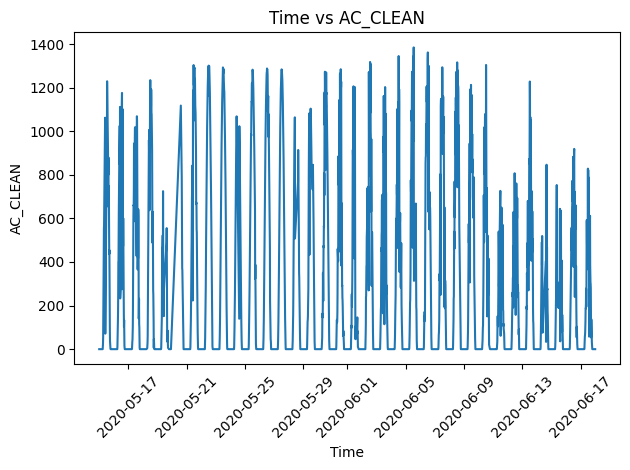

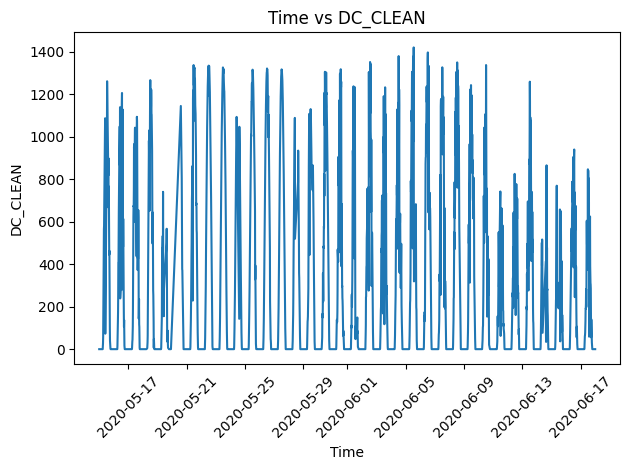

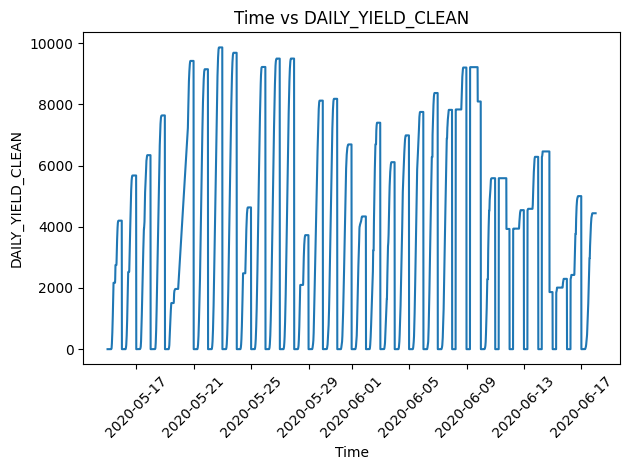

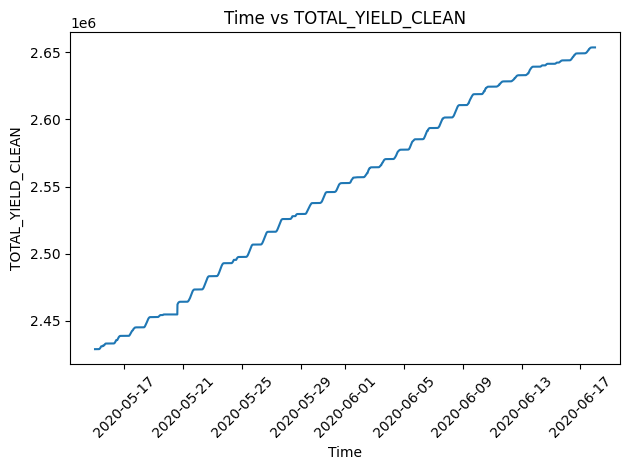

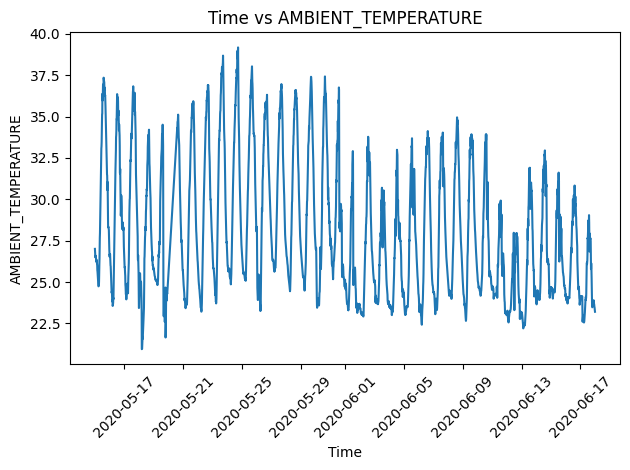

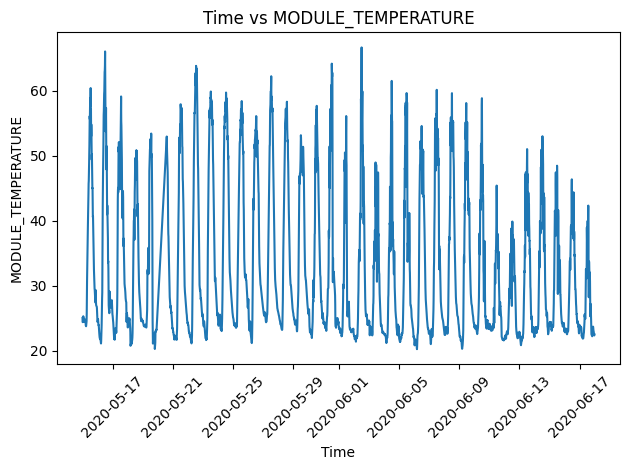

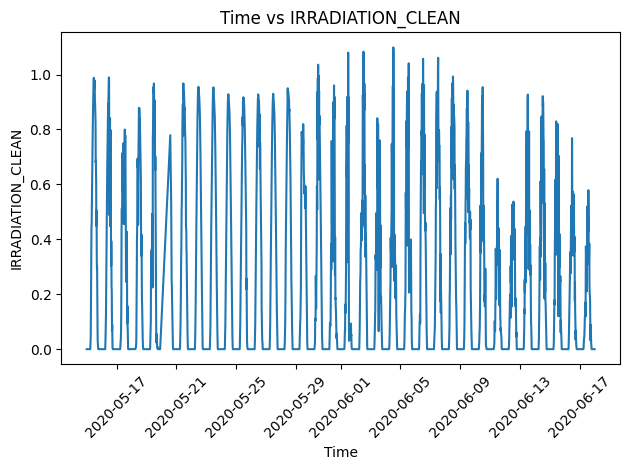

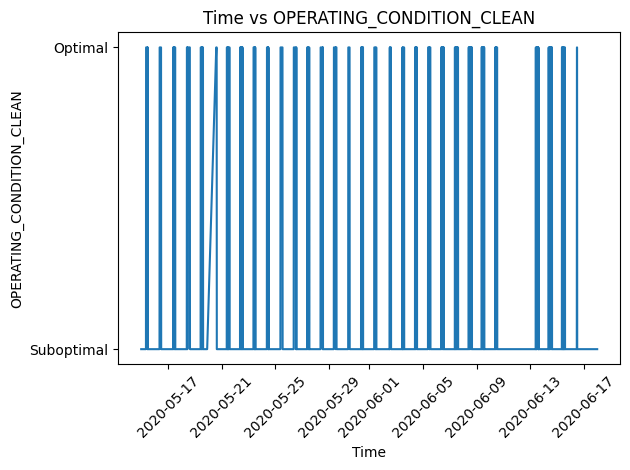

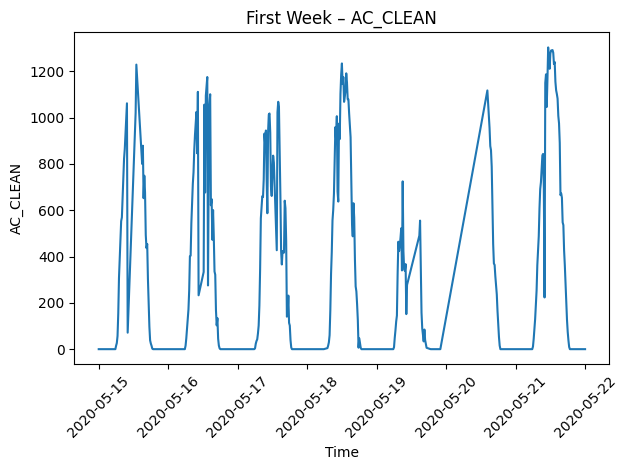

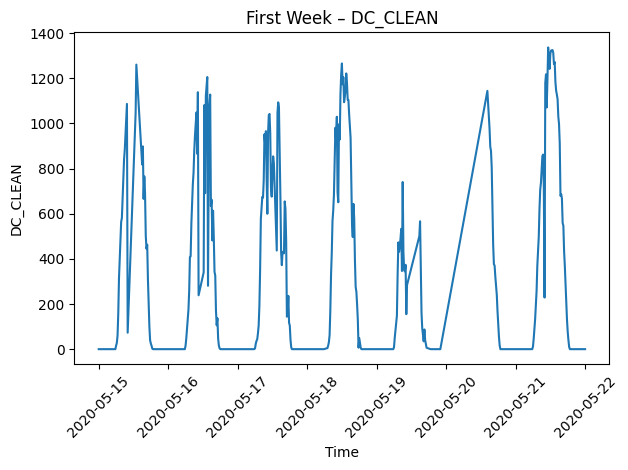

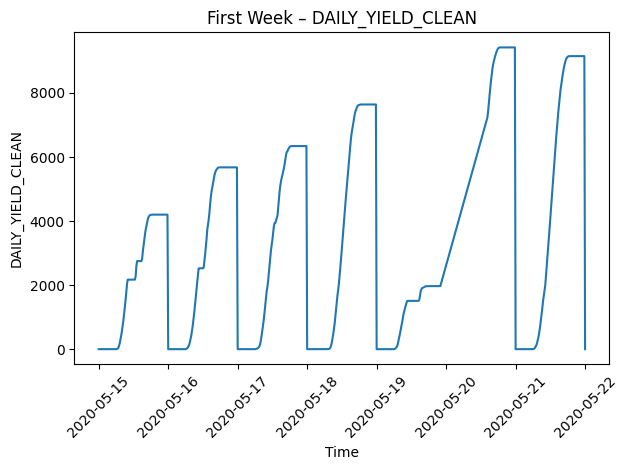

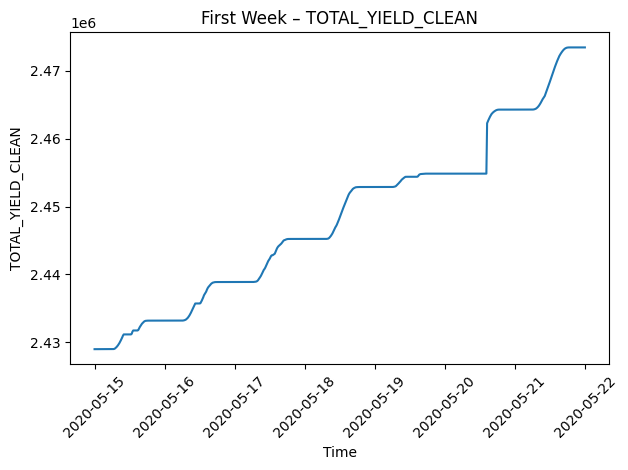

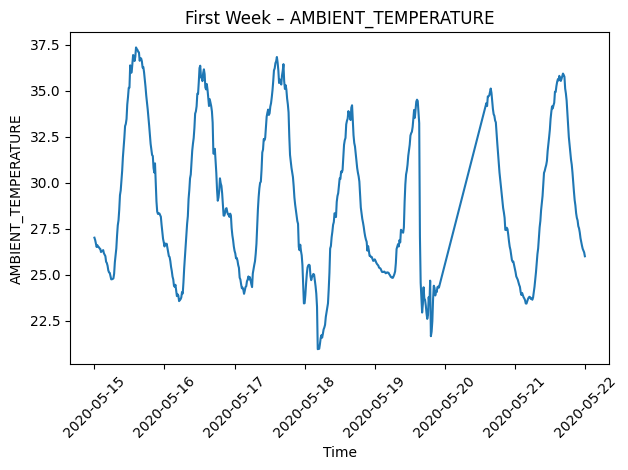

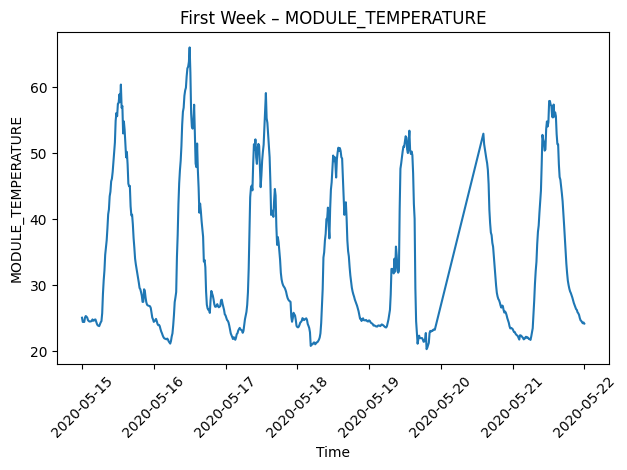

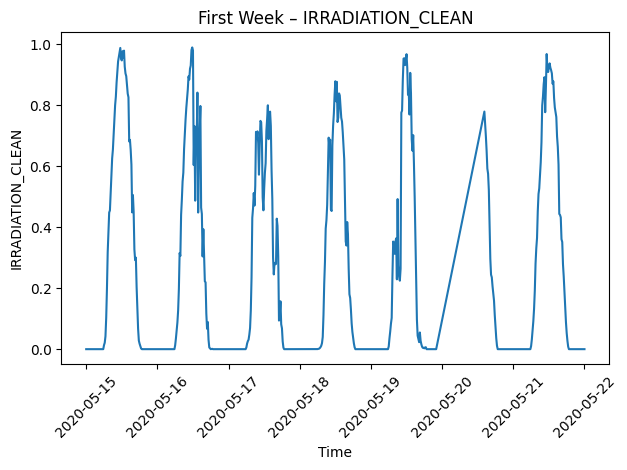

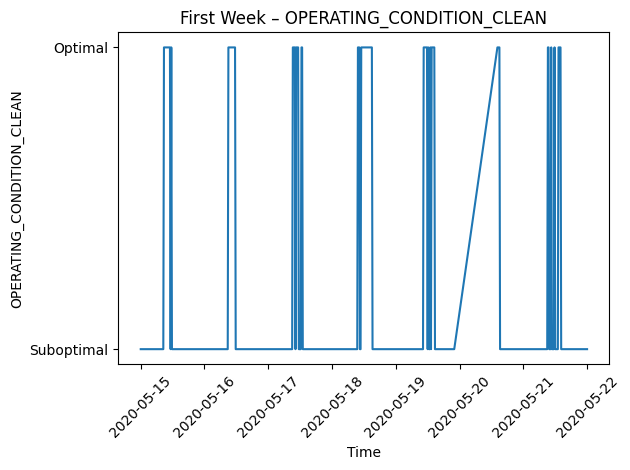

In [15]:
# Plot each cleaned variable over time
for col in eg1.columns:
    plt.figure()
    plt.plot(eg1.index, eg1[col])
    plt.title(f"Time vs {col}")
    plt.xlabel("Time")
    plt.ylabel(col)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

start = eg1.index.min()
end = start + pd.Timedelta(days=7)
eg2 = eg1.loc[start:end]

for col in eg2.columns:
    plt.figure()
    plt.plot(eg2.index, eg2[col])
    plt.title(f"First Week – {col}")
    plt.xlabel("Time")
    plt.ylabel(col)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

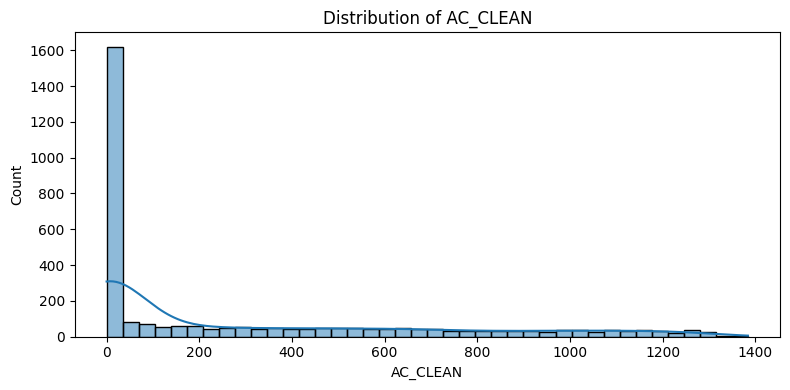

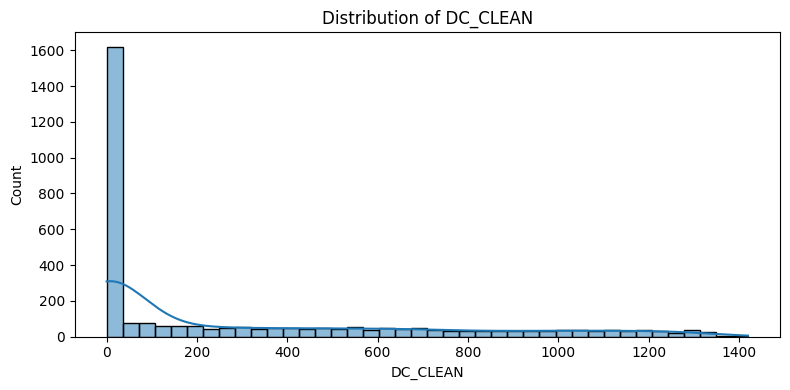

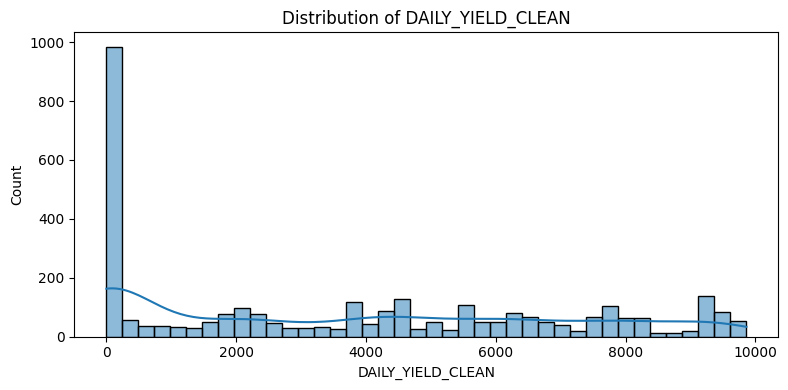

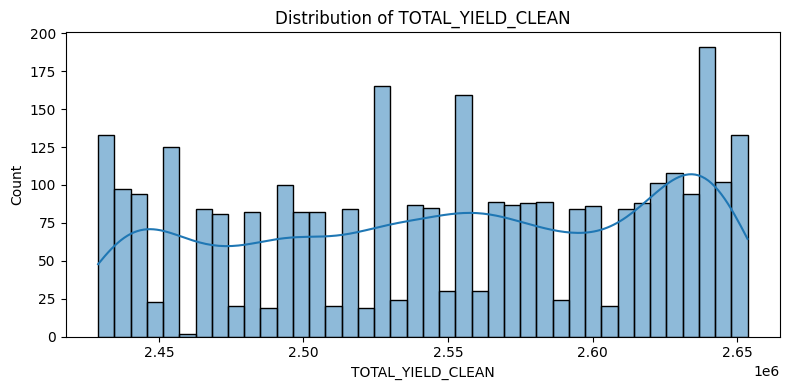

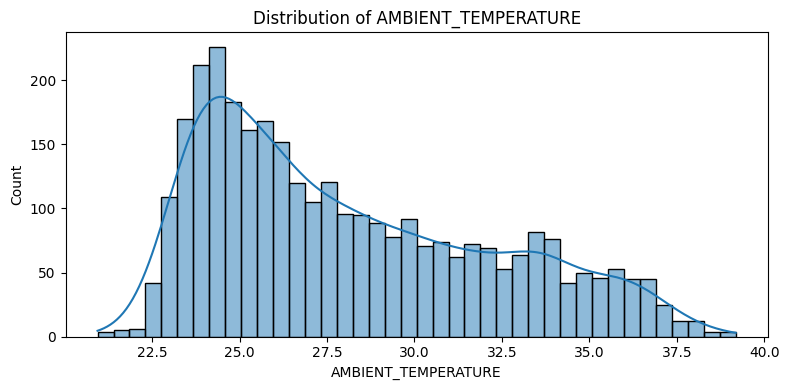

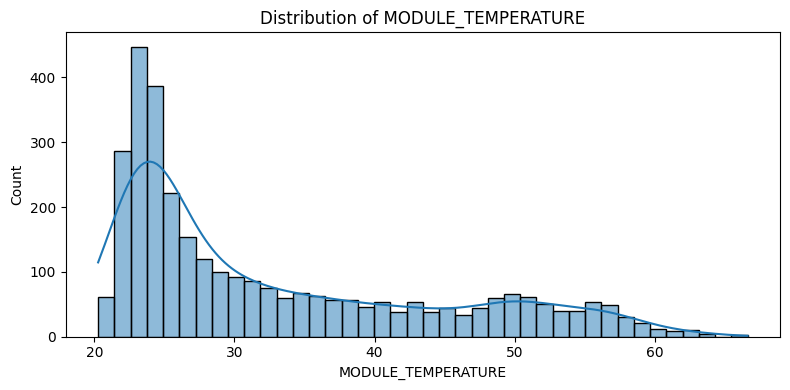

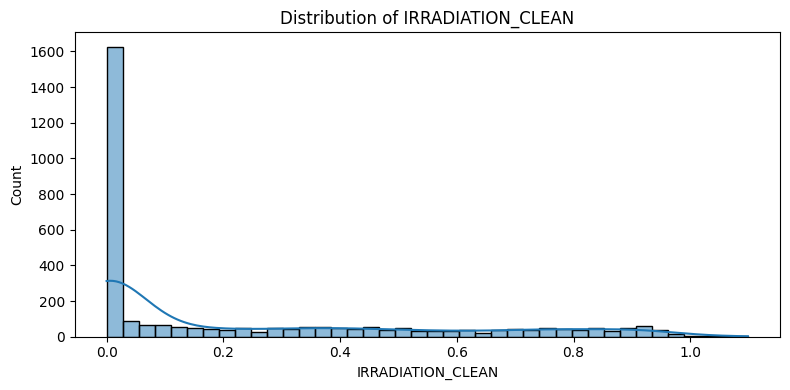

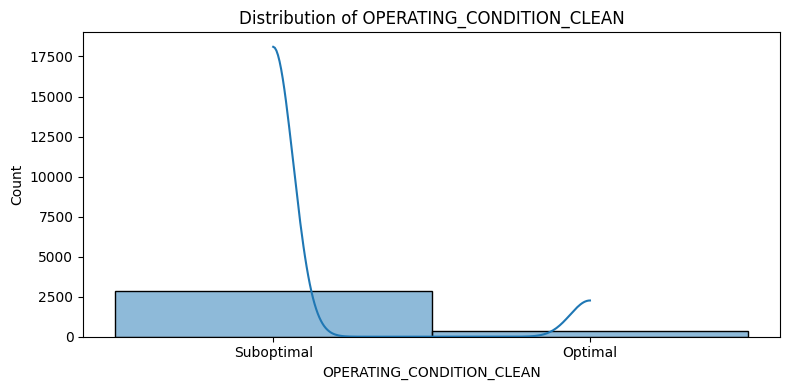

In [16]:
# Histogram plots for each cleaned inverter
for col in eg1.columns:
    plt.figure(figsize=(8, 4))
    sns.histplot(eg1[col], kde=True, bins=40)
    plt.title(f"Distribution of {col}")
    plt.xlabel(col)
    plt.tight_layout()
    plt.show()


---

## 📂 **Section 13 — Correlation Analysis**
**Description:**  
Computes correlation matrices for each inverter and visualizes one using a heatmap to observe relationships between power, yields, temperature, and irradiation.



Correlation matrix for inverter 4UPUqMRk7TRMgml:
                     AC_CLEAN  DC_CLEAN  DAILY_YIELD_CLEAN  TOTAL_YIELD_CLEAN  \
AC_CLEAN             1.000000  0.999997           0.126254          -0.081469   
DC_CLEAN             0.999997  1.000000           0.126195          -0.081660   
DAILY_YIELD_CLEAN    0.126254  0.126195           1.000000           0.043255   
TOTAL_YIELD_CLEAN   -0.081469 -0.081660           0.043255           1.000000   
AMBIENT_TEMPERATURE  0.649608  0.649447           0.514125          -0.292877   
MODULE_TEMPERATURE   0.899289  0.899295           0.259285          -0.164797   
IRRADIATION_CLEAN    0.932408  0.932456           0.094162          -0.091919   

                     AMBIENT_TEMPERATURE  MODULE_TEMPERATURE  \
AC_CLEAN                        0.649608            0.899289   
DC_CLEAN                        0.649447            0.899295   
DAILY_YIELD_CLEAN               0.514125            0.259285   
TOTAL_YIELD_CLEAN              -0.292877     

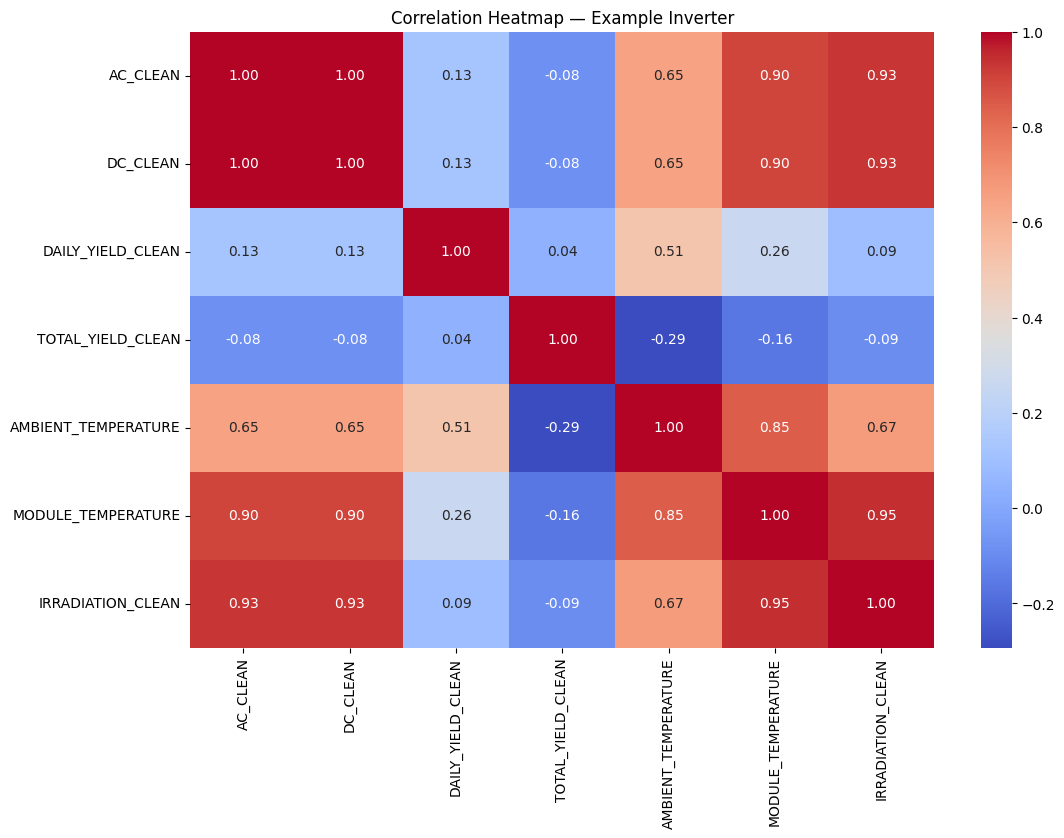

In [17]:
for sk, df in df_ps2.items():
    print(f"\nCorrelation matrix for inverter {sk}:")
    corr_matrix = df.drop(columns=["PLANT_ID", "SOURCE_KEY", "OPERATING_CONDITION_CLEAN"]).corr()
    print(corr_matrix)

eg_corr = df_ps2[source_key_2[0]].drop(columns=["PLANT_ID", "SOURCE_KEY", "OPERATING_CONDITION_CLEAN"])

plt.figure(figsize=(12, 8))
sns.heatmap(eg_corr.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap — Example Inverter")
plt.show()


---

## 📂 **Section 14 — Final Notes**
**Description:**  
Summary of cleaning workflow impact, dataset readiness, and potential next steps (e.g., modelling, fault detection).

In [18]:
print("\n--- FINAL NOTES ---")
print("• Data cleaning complete.")
print("• All AC/DC, yield, and irradiation signals cleaned.")
print("• Outliers processed using regression-residual detection.")
print("• EDA and correlation analyses generated successfully.")
print("• df_ps2 contains the fully cleaned dataset for all inverters.")
print("• df_ps2_outlier contains optional additional filtering.")

# OPTIONAL: Save cleaned data
# for sk, df in df_ps2.items():
#     df.to_csv(f"cleaned_inverter_{sk}.csv")



--- FINAL NOTES ---
• Data cleaning complete.
• All AC/DC, yield, and irradiation signals cleaned.
• Outliers processed using regression-residual detection.
• EDA and correlation analyses generated successfully.
• df_ps2 contains the fully cleaned dataset for all inverters.
• df_ps2_outlier contains optional additional filtering.


Same conclusion for feature selection as plant 1 since they exhibit similar results in correlation analysis.

Feature scaling will be further justified in the later training tasks